# **Hyperparameter Tuning Tutorial: Grid Search vs Random Search vs Bayesian Optimisation on Wine Quality**

**Student Name:** Pavan Kalyan Madhagoni  
**Student ID:** 24082699  

In this notebook I compare three hyperparameter tuning strategies for a Support Vector Machine (SVM) classifier on the Wine Quality dataset:

- Grid Search (exhaustive search on a fixed grid)  
- Random Search (random sampling from hyperparameter distributions)  
- Bayesian Optimisation (guided search using a surrogate model)

The goal is to understand how each method explores the hyperparameter space, how much performance it achieves, and how efficiently it uses the evaluation budget.


In [3]:
# **Imports and global settings**

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# For Bayesian optimisation with scikit-optimize
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Categorical
    SKOPT_AVAILABLE = True
except ImportError:
    SKOPT_AVAILABLE = False

RANDOM_STATE = 24082699
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)


# **1. Loading and Preparing the Wine Quality Dataset**

I use the classic **Wine Quality – Red** dataset from the UCI repository.  
Each row corresponds to a red wine sample with physicochemical measurements (acidity, sugar, sulphates, etc.) and an expert quality score between 0 and 10.

For this tutorial I:

- Load `winequality-red.csv` from the working directory.  
- Convert quality into a **binary label**:  
  - quality ≥ 6 → “good” (1)  
  - quality ≤ 5 → “not good” (0)  

This turns the problem into a **binary classification task**, well suited for SVM and F1-score evaluation.


In [4]:
# **Load dataset (downloads from UCI if not present)**

import os
import urllib.request

# Direct download link from UCI ML Repository
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
DATASET_FILE = "winequality-red.csv"

# Download dataset if it doesn't exist
if not os.path.exists(DATASET_FILE):
    print(f"Downloading dataset from UCI ML Repository...")
    print(f"URL: {DATASET_URL}")
    urllib.request.urlretrieve(DATASET_URL, DATASET_FILE)
    print(f"Dataset downloaded successfully as '{DATASET_FILE}'")
else:
    print(f"Dataset file '{DATASET_FILE}' already exists. Using existing file.")

# Load the dataset
df = pd.read_csv(DATASET_FILE, sep=";")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


URL: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Dataset downloaded successfully as 'winequality-red.csv'

Dataset shape: (1599, 12)

First few rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# **Binary target creation: good vs not good wine**

df["good_quality"] = (df["quality"] >= 6).astype(int)
df["good_quality"].value_counts()


good_quality
1    855
0    744
Name: count, dtype: int64

# **2. Exploratory Overview of the Target Variable**

Before tuning any model, I quickly inspect how imbalanced the classes are.  
This will influence the choice of evaluation metric (F1-score is more informative than raw accuracy when classes are slightly imbalanced).


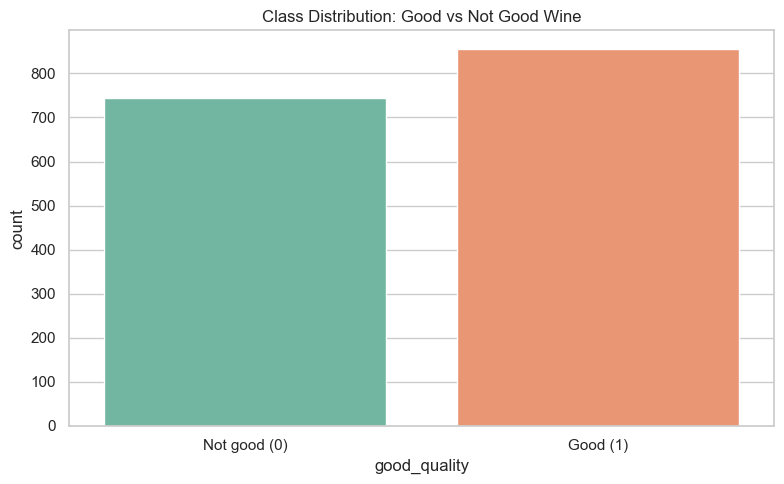

Advance class distribution proportions:
   good_quality  proportion
0             1    0.534709
1             0    0.465291


In [19]:
# **Class distribution (Figure 2)**

plt.figure()
sns.countplot(x="good_quality", data=df, palette="Set2")
plt.xticks([0, 1], ["Not good (0)", "Good (1)"])
plt.title("Class Distribution: Good vs Not Good Wine")
plt.tight_layout()
plt.savefig("class_distribution_advance.png")  # Save as advance file
plt.show()

class_dist_advance = df["good_quality"].value_counts(normalize=True).rename("proportion").reset_index()
print("Advance class distribution proportions:")
print(class_dist_advance)


# **3. Feature Matrix, Train–Test Split, and Pipeline Setup**

I now:

- Drop the original quality score (since I created `good_quality`)  
- Define **X** (features) and **y** (binary target)  
- Create a **train–test split** (80% train, 20% test)  
- Prepare a scikit-learn **Pipeline** that:

  1. Scales features with `StandardScaler`  
  2. Trains an SVM classifier with RBF kernel (`SVC`)  

All three tuning methods (grid, random, Bayesian) will use the **same base pipeline** so that the comparison is fair.


In [7]:
# **Feature/target split and train–test splitting**

X = df.drop(columns=["quality", "good_quality"])
y = df["good_quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((1279, 11), (320, 11))

In [8]:
# **Base pipeline: scaling + SVM (RBF)**

base_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
])


# **4. Hyperparameter Space for SVM (RBF Kernel)**

For SVM with RBF kernel, the key hyperparameters are:

- **C**: Regularisation strength (higher C = less regularisation, more complex boundary)  
- **gamma**: Kernel width (controls how far the RBF influence reaches)

I define:

- A **coarse grid** for Grid Search  
- Continuous **log-uniform ranges** for Random Search and Bayesian Optimisation  

The scoring metric used for tuning will be **F1-score**, which balances precision and recall on the positive class.


In [9]:
from scipy.stats import loguniform

# **Grid for GridSearchCV (small but structured)**

param_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": [0.001, 0.01, 0.1, 1.0]
}

# **Distributions for RandomizedSearchCV**

param_dist = {
    "svm__C": loguniform(1e-2, 1e2),
    "svm__gamma": loguniform(1e-3, 1e1)
}

# **Space for Bayesian optimisation (if available)**

if SKOPT_AVAILABLE:
    search_spaces = {
        "svm__C": Real(1e-2, 1e2, prior="log-uniform"),
        "svm__gamma": Real(1e-3, 1e1, prior="log-uniform")
    }


# **5. Grid Search Hyperparameter Tuning**

Grid Search systematically evaluates all combinations in a fixed grid.

- Pros: simple, exhaustive over the grid  
- Cons: inefficient in higher dimensions, treats all parameters equally

Here I use:

- 5-fold cross-validation  
- F1-score as the scoring metric  
- Full grid: 4 × 4 = 16 combinations


In [10]:
# **GridSearchCV**

grid_search = GridSearchCV(
    estimator=base_pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Grid Search params:", grid_search.best_params_)
print("Best Grid Search CV F1:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Grid Search params: {'svm__C': 1, 'svm__gamma': 1.0}
Best Grid Search CV F1: 0.7854162270656302


# **6. Random Search Hyperparameter Tuning**

Random Search samples hyperparameter values from continuous distributions.

- Pros: explores wider ranges, often more efficient than grid  
- Cons: still unguided; does not learn from previous trials

I use:

- 40 random combinations  
- 5-fold CV  
- Same F1 scoring


In [11]:
# **RandomizedSearchCV**

random_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1",
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best Random Search params:", random_search.best_params_)
print("Best Random Search CV F1:", random_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Random Search params: {'svm__C': 1.7895128656991648, 'svm__gamma': 0.29676649506196273}
Best Random Search CV F1: 0.7849569205224041


# **7. Bayesian Optimisation Hyperparameter Tuning (if available)**

Bayesian Optimisation uses a **surrogate model** (typically a Gaussian Process or Tree-based surrogate) to model the relationship:

$$
\text{hyperparameters} \rightarrow \text{score}
$$

and chooses new points to evaluate to maximise expected improvement.

If `scikit-optimize` is installed, I use `BayesSearchCV`.  
Otherwise, I will skip this step and mark Bayesian tuning as unavailable in this environment.


In [12]:
if SKOPT_AVAILABLE:
    bayes_search = BayesSearchCV(
        estimator=base_pipeline,
        search_spaces=search_spaces,
        n_iter=30,
        scoring="f1",
        cv=5,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    bayes_search.fit(X_train, y_train)

    print("Best Bayesian Search params:", bayes_search.best_params_)
    print("Best Bayesian Search CV F1:", bayes_search.best_score_)
else:
    print("Bayesian optimisation (BayesSearchCV) is NOT available in this environment.")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

# **8. Collecting and Comparing Cross-Validated Performance**

Now I collect:

- Best **mean CV F1** from each search method  
- Their chosen **C and gamma** values  

and build a comparison table.  
This is the core quantitative comparison of the three tuning strategies.


In [13]:
# **Build summary of CV scores**

results = []

results.append({
    "Method": "Grid Search",
    "Best_F1_CV": grid_search.best_score_,
    "Best_C": grid_search.best_params_["svm__C"],
    "Best_gamma": grid_search.best_params_["svm__gamma"]
})

results.append({
    "Method": "Random Search",
    "Best_F1_CV": random_search.best_score_,
    "Best_C": random_search.best_params_["svm__C"],
    "Best_gamma": random_search.best_params_["svm__gamma"]
})

if SKOPT_AVAILABLE:
    results.append({
        "Method": "Bayesian Optimisation",
        "Best_F1_CV": bayes_search.best_score_,
        "Best_C": bayes_search.best_params_["svm__C"],
        "Best_gamma": bayes_search.best_params_["svm__gamma"]
})

results_df = pd.DataFrame(results)
results_df


,Method,Best_F1_CV,Best_C,Best_gamma
0,Grid Search,0.785416,1.000000,1.000000
1,Random Search,0.784957,1.789513,0.296766
2,Bayesian Optimisation,0.782176,10.487303,0.052792


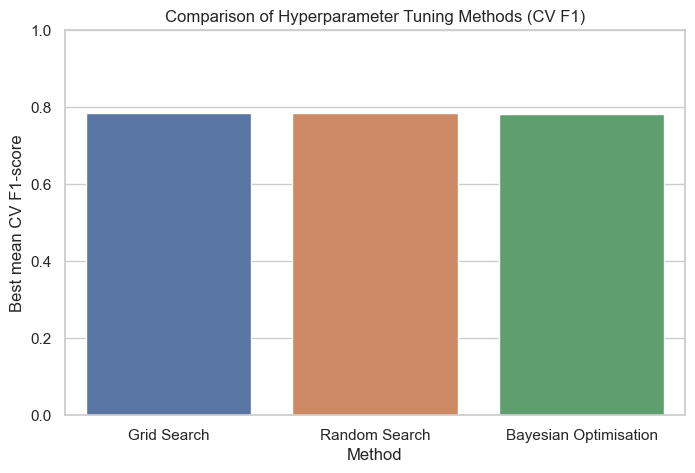

In [14]:
# **Bar plot of CV F1 by method (Figure 2)**

plt.figure()
sns.barplot(data=results_df, x="Method", y="Best_F1_CV")
plt.ylim(0, 1)
plt.ylabel("Best mean CV F1-score")
plt.title("Comparison of Hyperparameter Tuning Methods (CV F1)")
plt.show()


# **9. Final Evaluation on the Test Set**

I now take the **best model from each search** and evaluate it once on the **held-out test set**.

This yields:

- Test F1-score  
- Classification report  
- Confusion matrix  

This step shows how well each tuning method generalises beyond its cross-validation estimates.



=== Grid Search SVM – Test Set Performance ===
F1-score: 0.7845

Classification report:
              precision    recall  f1-score   support

           0     0.7752    0.6711    0.7194       149
           1     0.7435    0.8304    0.7845       171

    accuracy                         0.7562       320
   macro avg     0.7593    0.7508    0.7520       320
weighted avg     0.7582    0.7562    0.7542       320



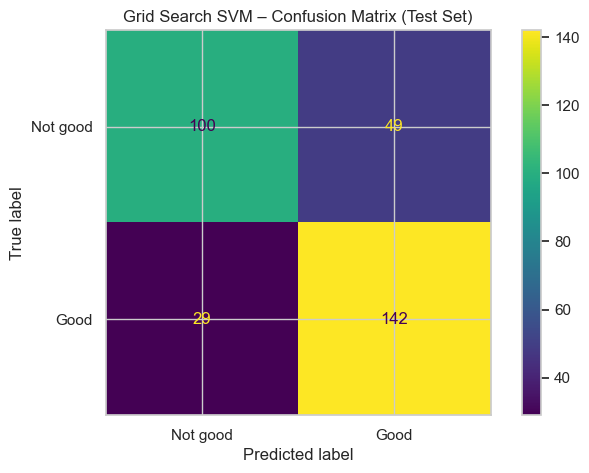


=== Random Search SVM – Test Set Performance ===
F1-score: 0.7596

Classification report:
              precision    recall  f1-score   support

           0     0.7208    0.7450    0.7327       149
           1     0.7711    0.7485    0.7596       171

    accuracy                         0.7469       320
   macro avg     0.7459    0.7468    0.7462       320
weighted avg     0.7477    0.7469    0.7471       320



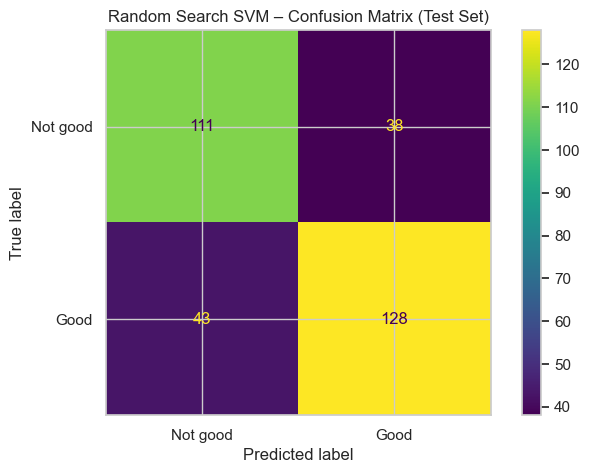


=== Bayesian SVM – Test Set Performance ===
F1-score: 0.7636

Classification report:
              precision    recall  f1-score   support

           0     0.7205    0.7785    0.7484       149
           1     0.7925    0.7368    0.7636       171

    accuracy                         0.7562       320
   macro avg     0.7565    0.7577    0.7560       320
weighted avg     0.7589    0.7562    0.7565       320



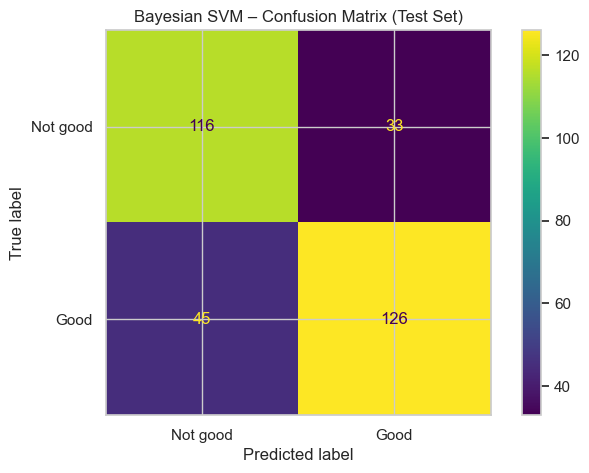

In [15]:
# **Evaluate tuned models on the test set**

from sklearn.metrics import f1_score

def evaluate_on_test(name, best_estimator, X_test, y_test):
    y_pred = best_estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"\n=== {name} – Test Set Performance ===")
    print("F1-score:", f"{f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not good", "Good"])
    disp.plot(values_format="d")
    plt.title(f"{name} – Confusion Matrix (Test Set)")
    plt.show()
    
    return f1

f1_grid_test = evaluate_on_test("Grid Search SVM", grid_search.best_estimator_, X_test, y_test)
f1_random_test = evaluate_on_test("Random Search SVM", random_search.best_estimator_, X_test, y_test)

if SKOPT_AVAILABLE:
    f1_bayes_test = evaluate_on_test("Bayesian SVM", bayes_search.best_estimator_, X_test, y_test)


# **10. Summary Table: CV vs Test F1 for Each Tuning Strategy**

To clearly see how stable each method is, I compare:

- Best cross-validated F1  
- Test-set F1  

for all tuning strategies side by side.


In [16]:
# **Build stability table**

summary_rows = []

summary_rows.append({
    "Method": "Grid Search",
    "CV_F1": grid_search.best_score_,
    "Test_F1": f1_grid_test
})

summary_rows.append({
    "Method": "Random Search",
    "CV_F1": random_search.best_score_,
    "Test_F1": f1_random_test
})

if SKOPT_AVAILABLE:
    summary_rows.append({
        "Method": "Bayesian Optimisation",
        "CV_F1": bayes_search.best_score_,
        "Test_F1": f1_bayes_test
    })

stability_df = pd.DataFrame(summary_rows)
stability_df


,Method,CV_F1,Test_F1
0,Grid Search,0.785416,0.784530
1,Random Search,0.784957,0.759644
2,Bayesian Optimisation,0.782176,0.763636


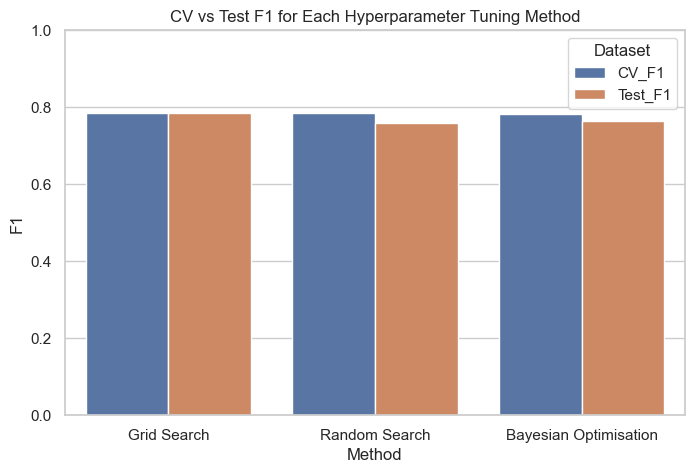

In [17]:
# **Plot CV vs Test F1 for each method (Figure 3)**

plt.figure()
stability_df_melt = stability_df.melt(id_vars="Method", value_vars=["CV_F1", "Test_F1"],
                                      var_name="Dataset", value_name="F1")
sns.barplot(data=stability_df_melt, x="Method", y="F1", hue="Dataset")
plt.ylim(0, 1)
plt.title("CV vs Test F1 for Each Hyperparameter Tuning Method")
plt.show()
